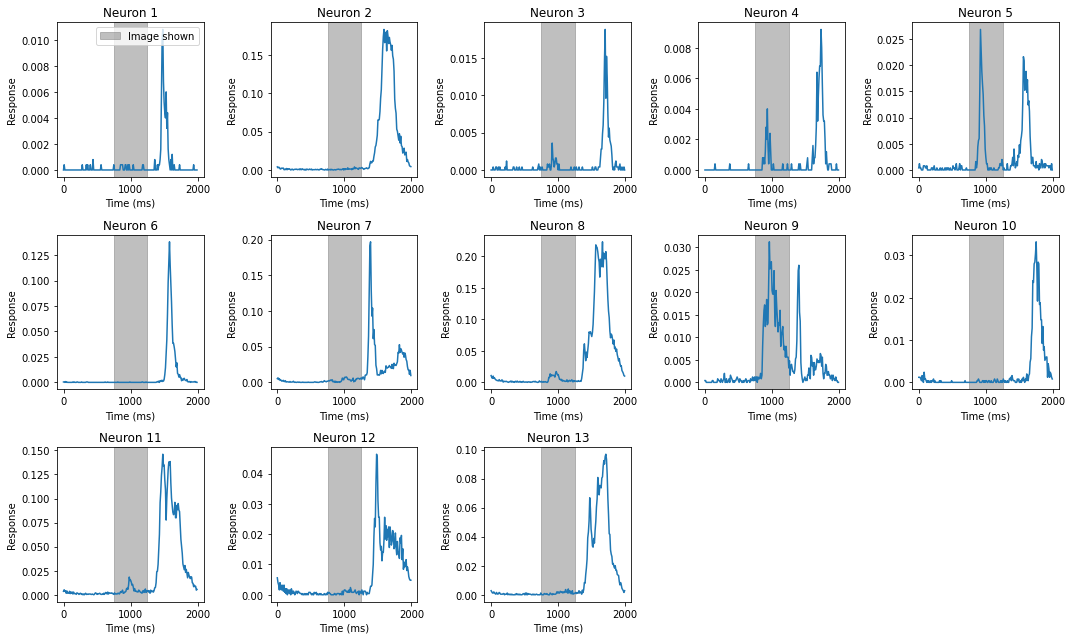

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

# Import functions and classes from the libraries
from fundamental_library import *

# File paths
images_path = '/project/../data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'

# Load Images to np.array
images = np.load(images_path)

# Load responses and preprocess them
v1_responses, _, _ = load_mat_file(v1_responses_path)
v1_responses = np.transpose(v1_responses, (1, 2, 0))

# Look at mean data for neurons
v1_responses_mean = np.mean(v1_responses, axis=0, keepdims=True)

# Define the number of plots
num_plots = 13
neuron_indices = range(num_plots)

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

# Create a custom legend patch
legend_patch = mpatches.Patch(color='gray', alpha=0.5, label='Image shown')

# Plot each neuron data
x = np.arange(0, 2000, 10)
for i, neuron_index in enumerate(neuron_indices):
    if i < len(neuron_indices):  # Ensure we don't go out of bounds
        neuron_mean = v1_responses_mean[:, :, neuron_index]
        axs[i].plot(x, neuron_mean[0, :])
        axs[i].axvspan(750, 1250, color='gray', alpha=0.5)  # Add transparent gray tile
        axs[i].set_title(f'Neuron {neuron_index + 1}')
        axs[i].set_xlabel('Time (ms)')
        axs[i].set_ylabel('Response')
        # Add the legend to the first plot only to avoid repetition
        if i == 0:
            axs[i].legend(handles=[legend_patch])

# Remove empty subplots (if any)
for j in range(len(neuron_indices), len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.show()



(2500, 13)
uint8
(2500,)


<ipython-input-4-7f4f9023cd40>:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


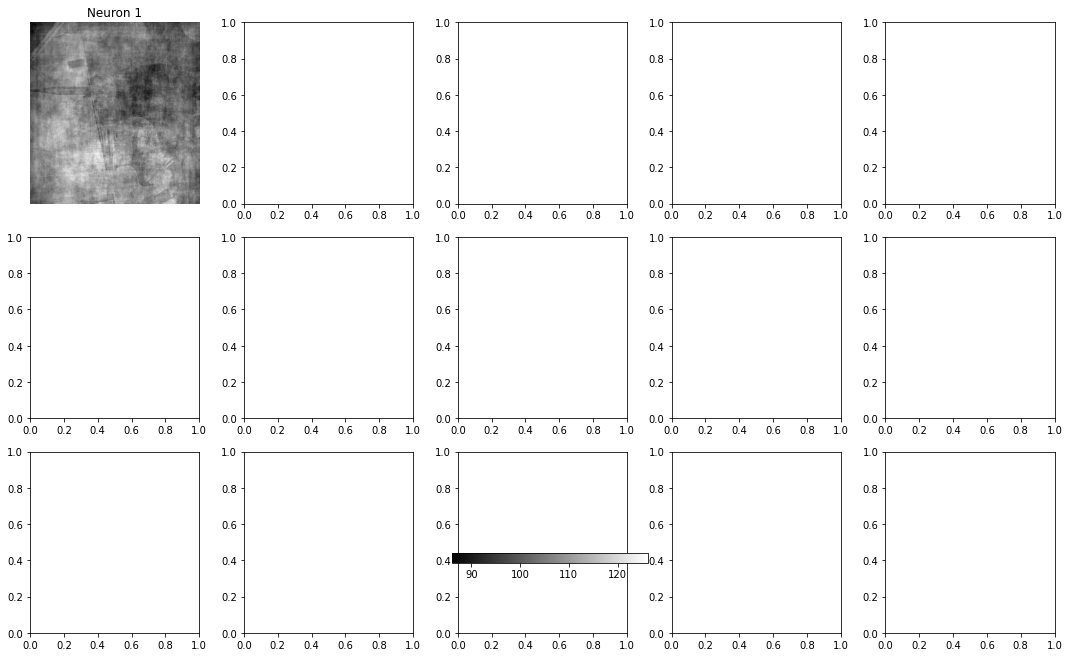

In [4]:
# plot images for neurons.
v1_responses_sum=np.sum(v1_responses, axis=1,dtype='uint8')
print(v1_responses_sum.shape)
print(images.dtype)


# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

for i in range(1):
    weights=v1_responses_sum[:,i]/np.sum(v1_responses_sum[:,i])
    print(weights.shape)
    weighted_means=np.average(images,axis=0,weights=weights)
    im = axs[i].imshow(weighted_means, aspect='auto', cmap='gray')
    axs[i].set_title(f'Neuron {i+1}')
    axs[i].axis('off')

fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()



<ipython-input-5-ec7be7609adf>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


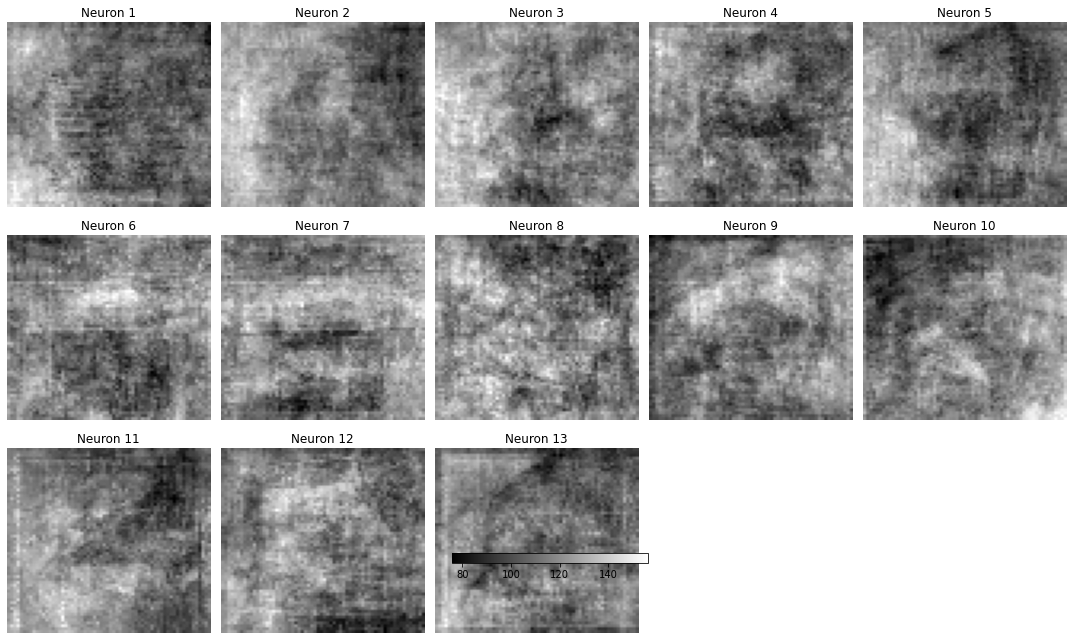

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from fundamental_library import *

# Number of images to process
n = 2500

# File paths
images_path = '/project/subiculum/data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'

# Load Images to np.array
images = np.load(images_path)[0:n, :, :]

# Load responses and preprocess them
v1_responses, _, _ = load_mat_file(v1_responses_path)
v1_responses = np.transpose(v1_responses, (1, 2, 0))[0:n, :, :]

# Set device to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a function to process images in batches
def downscale_images_in_batches(images, batch_size=50):  # Reduced batch size
    downscaled_images = []
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        batch = images[i * batch_size:(i + 1) * batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
        downscaled_batch = F.interpolate(batch_tensor.unsqueeze(1), size=(64, 64), mode='bilinear', align_corners=False)
        downscaled_batch = downscaled_batch.squeeze(1).cpu().numpy()
        downscaled_images.append(downscaled_batch)
        del batch_tensor, downscaled_batch  # Clear GPU memory
        torch.cuda.empty_cache()  # Free up unused memory
    
    return np.concatenate(downscaled_images, axis=0)

# Downscale images in batches
images_downscaled = downscale_images_in_batches(images, batch_size=1)

# Sum the responses across time
v1_responses_sum = np.sum(v1_responses, axis=2, dtype='uint8')
v1_responses_sum = torch.tensor(v1_responses_sum).to(device)

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

for i in range(13):
    weights = v1_responses_sum[:, i].float()
    weights_normalized = weights / weights.sum()
    weighted_means = torch.einsum('ijk,i->jk', torch.tensor(images_downscaled).to(device), weights_normalized)
    weighted_means_np = weighted_means.cpu().numpy()
    im = axs[i].imshow(weighted_means_np, aspect='auto', cmap='gray')
    axs[i].set_title(f'Neuron {i+1}')
    axs[i].axis('off')
    del weights, weights_normalized, weighted_means, weighted_means_np  # Clear GPU memory
    torch.cuda.empty_cache()  # Free up unused memory

# Remove empty subplots
for j in range(13, len(axs)):
    fig.delaxes(axs[j])

fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()





resp sape(2500, 200, 13)
(2500, 13)


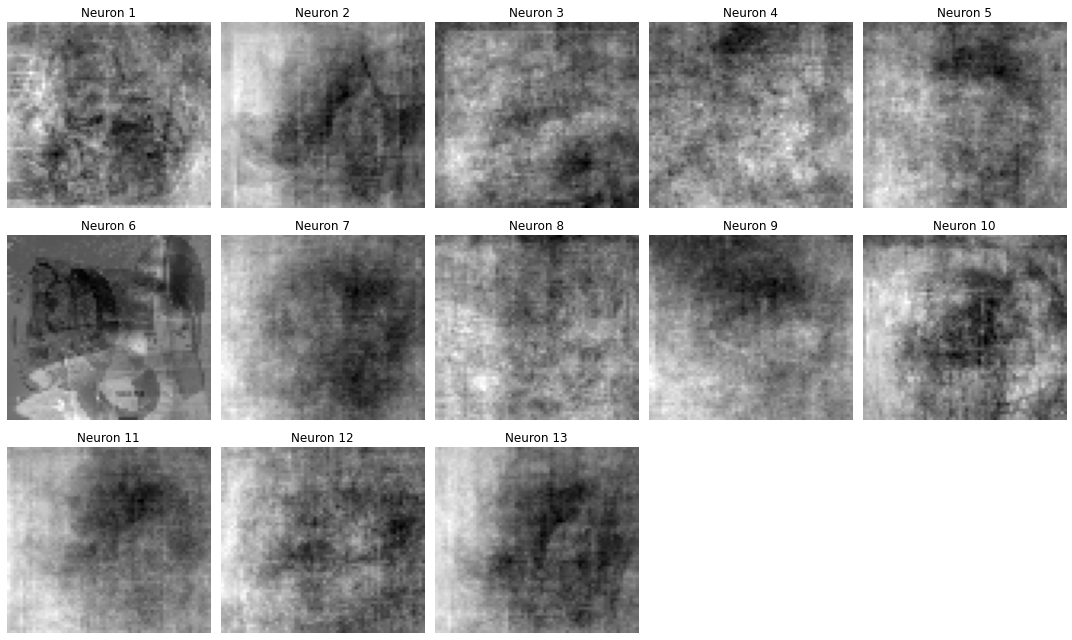

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Import functions and classes from the libraries
from fundamental_library import *

# File paths
images_path = '/project/subiculum/data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'

# Load Images to np.array
images = np.load(images_path)

# Load responses and preprocess them
v1_responses, _, _ = load_mat_file(v1_responses_path)
v1_responses = np.transpose(v1_responses, (1, 2, 0))
print(f"resp sape{v1_responses.shape}")
# Sum the responses across time
v1_responses_sum = np.sum(v1_responses[:,75:125,:], axis=1, dtype='uint8')
print(v1_responses_sum.shape)

# Set device to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a function to process images in batches
def downscale_images_in_batches(images, batch_size=100):
    downscaled_images = []
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        batch = images[i * batch_size:(i + 1) * batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
        downscaled_batch = F.interpolate(batch_tensor.unsqueeze(1), size=(64, 64), mode='bilinear', align_corners=False)
        downscaled_batch = downscaled_batch.squeeze(1).cpu().numpy()
        downscaled_images.append(downscaled_batch)
    
    return np.concatenate(downscaled_images, axis=0)

# Downscale images in batches
images_downscaled = downscale_images_in_batches(images, batch_size=100)

# Convert the summed responses to a PyTorch tensor
v1_responses_sum = torch.tensor(v1_responses_sum, dtype=torch.float32).to(device)

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

for i in range(13):
    weights = v1_responses_sum[:, i]
    weights_normalized = weights / weights.sum()
    weighted_means = torch.einsum('ijk,i->jk', torch.tensor(images_downscaled).to(device), weights_normalized)
    weighted_means_np = weighted_means.cpu().numpy()
    im = axs[i].imshow(weighted_means_np, aspect='auto', cmap='gray')
    axs[i].set_title(f'Neuron {i+1}')
    axs[i].axis('off')

# Remove empty subplots
for j in range(13, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


(2500, 13)


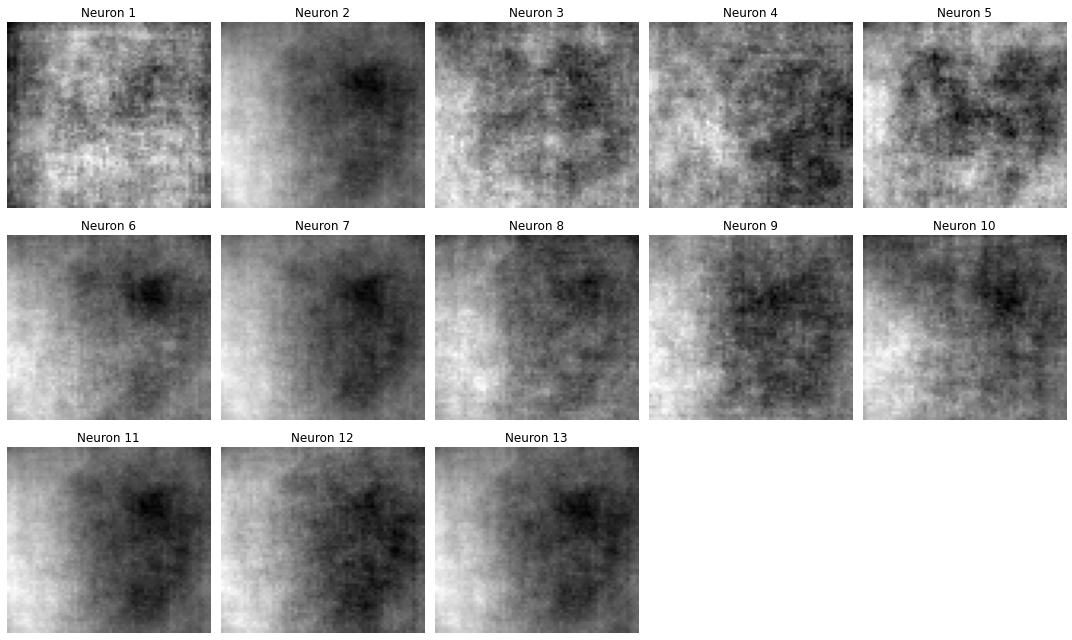

In [41]:
v1_responses_sum = np.sum(v1_responses[:,125:199,:], axis=1, dtype='uint8')
print(v1_responses_sum.shape)

# Set device to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a function to process images in batches
def downscale_images_in_batches(images, batch_size=100):
    downscaled_images = []
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        batch = images[i * batch_size:(i + 1) * batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
        downscaled_batch = F.interpolate(batch_tensor.unsqueeze(1), size=(64, 64), mode='bilinear', align_corners=False)
        downscaled_batch = downscaled_batch.squeeze(1).cpu().numpy()
        downscaled_images.append(downscaled_batch)
    
    return np.concatenate(downscaled_images, axis=0)

# Downscale images in batches
images_downscaled = downscale_images_in_batches(images, batch_size=100)

# Convert the summed responses to a PyTorch tensor
v1_responses_sum = torch.tensor(v1_responses_sum, dtype=torch.float32).to(device)

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

for i in range(13):
    weights = v1_responses_sum[:, i]
    weights_normalized = weights / weights.sum()
    weighted_means = torch.einsum('ijk,i->jk', torch.tensor(images_downscaled).to(device), weights_normalized)
    weighted_means_np = weighted_means.cpu().numpy()
    im = axs[i].imshow(weighted_means_np, aspect='auto', cmap='gray')
    axs[i].set_title(f'Neuron {i+1}')
    axs[i].axis('off')

# Remove empty subplots
for j in range(13, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Original images shape: (2500, 1200, 1200)
Original v1_responses shape: (2500, 200, 13)
Summed v1_responses shape: (2500, 13)
Images dtype: uint8
Downscaled images shape: (2500, 64, 64)


<ipython-input-7-d3f204ca5eb5>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


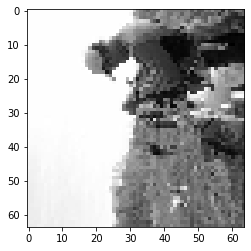

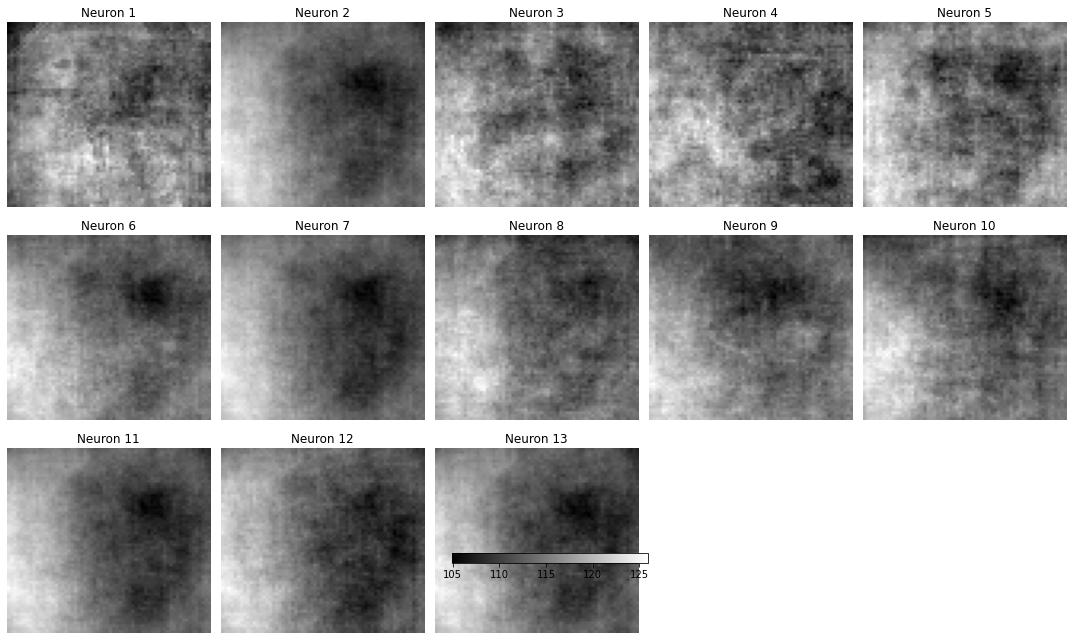

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Import functions and classes from the libraries
from fundamental_library import *

# File paths
images_path = '/project/subiculum/data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'

# Load Images to np.array
images = np.load(images_path)
print(f"Original images shape: {images.shape}")

# Load responses and preprocess them
v1_responses, _, _ = load_mat_file(v1_responses_path)
v1_responses = np.transpose(v1_responses, (1, 2, 0))
print(f"Original v1_responses shape: {v1_responses.shape}")

# Sum the responses across the time axis
v1_responses_sum = np.sum(v1_responses, axis=1)
print(f"Summed v1_responses shape: {v1_responses_sum.shape}")
print(f"Images dtype: {images.dtype}")

# Set device to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define a function to process images in batches and downscale them to 64x64
def downscale_images_in_batches(images, batch_size=100):
    downscaled_images = []
    num_batches = len(images) // batch_size + (1 if len(images) % batch_size != 0 else 0)
    
    for i in range(num_batches):
        batch = images[i * batch_size:(i + 1) * batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
        downscaled_batch = F.interpolate(batch_tensor.unsqueeze(1), size=(64, 64), mode='bilinear', align_corners=False)
        downscaled_batch = downscaled_batch.squeeze(1).cpu().numpy()
        downscaled_images.append(downscaled_batch)
    
    return np.concatenate(downscaled_images, axis=0)

# Downscale images in batches
images_downscaled = downscale_images_in_batches(images, batch_size=100)
plt.imshow(images_downscaled[0],cmap='gray')
print(f"Downscaled images shape: {images_downscaled.shape}")

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

# Calculate the weighted means and plot the images
for i in range(13):
    weighted_means = np.average(images_downscaled, axis=0, weights=v1_responses_sum[:, i])
    im = axs[i].imshow(weighted_means, aspect='auto', cmap='gray')
    axs[i].set_title(f'Neuron {i+1}')
    axs[i].axis('off')

# Remove empty subplots
for j in range(13, len(axs)):
    fig.delaxes(axs[j])

fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()


Original images shape: (2500, 1200, 1200)
Original v1_responses shape: (2500, 200, 13)
Summed v1_responses shape: (2500, 13)
Images dtype: uint8


<ipython-input-4-98b5bf9796cc>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


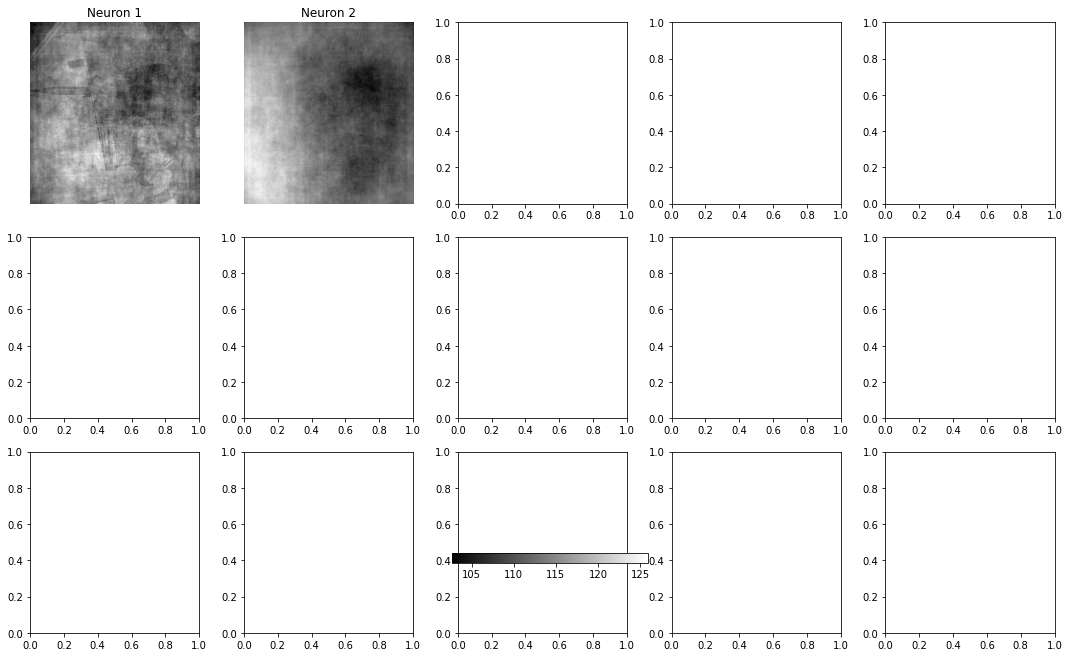

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Import functions and classes from the libraries
from fundamental_library import *

# File paths
images_path = '/project/subiculum/data/images_uint8.npy'
v1_responses_path = '/project/subiculum/data/V1_Data.mat'

# Load Images to np.array
images = np.load(images_path)
print(f"Original images shape: {images.shape}")

# Load responses and preprocess them
v1_responses, _, _ = load_mat_file(v1_responses_path)
v1_responses = np.transpose(v1_responses, (1, 2, 0))
print(f"Original v1_responses shape: {v1_responses.shape}")

# Sum the responses across the time axis
v1_responses_sum = np.sum(v1_responses, axis=1)
print(f"Summed v1_responses shape: {v1_responses_sum.shape}")
print(f"Images dtype: {images.dtype}")

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

for i in range(2):
    weighted_means = np.average(images, axis=0, weights=v1_responses_sum[:, i] / np.sum(v1_responses_sum[:, i]))
    im = axs[i].imshow(weighted_means, aspect='auto', cmap='gray')
    axs[i].set_title(f'Neuron {i+1}')
    axs[i].axis('off')

fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()

# plot images for neurons.
v1_responses_sum=np.sum(v1_responses, axis=1,dtype='uint8')
print(v1_responses_sum.shape)
print(images.dtype)


# Create a 3x5 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

for i in range(2):
    weights=v1_responses_sum[:,i]/np.sum(v1_responses_sum[:,i])
    print(weights.shape)
    weighted_means=np.average(images,axis=0,weights=weights)
    im = axs[i].imshow(weighted_means, aspect='auto', cmap='gray')
    axs[i].set_title(f'Neuron {i+1}')
    axs[i].axis('off')

fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.04)
plt.tight_layout()
plt.show()

In [2]:
import os
import numpy as np
import torch

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set the root directory
root_dir = '/project/data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6/data'

# Initialize lists to collect data
responses_list = []
images_list = []

# Load the data
for n in range(5994):
    image_path = os.path.join(root_dir, 'images', f'{n}.npy')
    response_path = os.path.join(root_dir, 'responses', f'{n}.npy')
    
    response_data = np.load(response_path)
    image_data = np.load(image_path)
    
    responses_list.append(response_data)
    images_list.append(image_data)
    
# Convert lists to NumPy arrays
responses = np.array(responses_list)
images = np.array(images_list)

# Optionally convert to PyTorch tensors
responses_tensor = torch.tensor(responses, device=device)
images_tensor = torch.tensor(images, device=device)

print("Responses Tensor Shape:", responses_tensor.shape)
print("Images Tensor Shape:", images_tensor.shape)




Responses Tensor Shape: torch.Size([5994, 8372])
Images Tensor Shape: torch.Size([5994, 1, 144, 256])


(5994, 1, 144, 256)


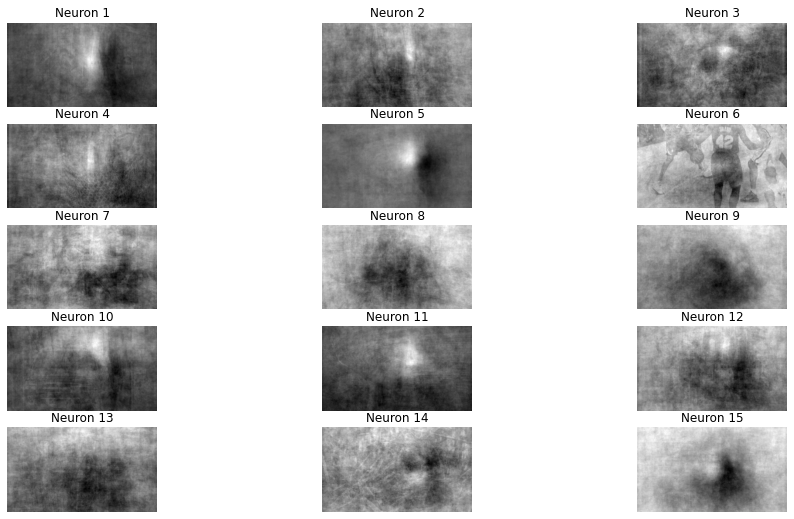

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Convert PyTorch tensors to NumPy arrays if necessary
images = images_tensor.cpu().numpy() if isinstance(images_tensor, torch.Tensor) else images_tensor
responses = responses_tensor.cpu().numpy() if isinstance(responses_tensor, torch.Tensor) else responses_tensor
print(images.shape)

# Flatten images array for easier processing if necessary
images = images.reshape(images.shape[0], -1)

# Number of neurons to visualize
num_neurons = responses.shape[1]

# Define image dimensions for a 16:9 aspect ratio
image_height = 144
image_width = 256

# Create a 3x5 grid of subplots
fig, axs = plt.subplots(5, 3, figsize=(16, 9))
axs = axs.flatten()  # Flatten the 2D array to 1D for easier iteration

# Calculate the weighted means and plot the images for each neuron
for i in range(min(num_neurons, len(axs))):
    weights = responses[:, i] / np.sum(responses[:, i])
    weighted_means = np.average(images, axis=0, weights=weights)
    weighted_means_image = weighted_means.reshape(image_height, image_width)
    extent= (0,16,0,9)
    im = axs[i].imshow(weighted_means_image, cmap='gray')
    axs[i].set_title(f'Neuron {i+1}')  
    axs[i].axis('off')

# Remove empty subplots
for j in range(num_neurons, len(axs)):
    fig.delaxes(axs[j])

plt.show()




In [9]:
print(144*16/9)

256.0
